In [397]:
import json
from pathlib import Path

from utils.util import *
%matplotlib inline

discriminator_folder = "../experiment_results/discriminator_0.8_test"
csv_name = "discriminator_pred_on_test.csv"
output_dir = "classifier_analysis"

Path(output_dir).mkdir(parents=True, exist_ok=True)

In [398]:
# init data
discriminator_results = pd.read_csv(os.path.join(discriminator_folder, csv_name))
catboost_results = pd.read_csv(os.path.join(output_dir, "catboost_results.csv"))

with open(os.path.join(discriminator_folder, "class_id_map.json"), 'r') as file:
    json_data = file.read()

class_to_id = json.loads(json_data)
id_to_class = {class_id: class_name for class_name, class_id in class_to_id.items()}
discriminator_results["class_name_real"] = discriminator_results["class_real"].replace(id_to_class)
discriminator_results["class_name_pred"] = discriminator_results["class_pred"].replace(id_to_class)
catboost_results["class_name_real"] = catboost_results["class_real"].replace(id_to_class)
catboost_results["class_name_pred"] = catboost_results["class_pred"].replace(id_to_class)
discriminator_results

,class_pred,class_real,real_fake_pred,class_name_real,class_name_pred
0,10,21,0.183846,YRI,ACB
1,3,5,0.101945,CLM,PEL
2,22,8,0.055887,LWK,FIN
3,13,18,0.056836,KHV,CDX
4,18,18,0.583189,KHV,KHV
...,...,...,...,...,...
995,16,1,0.107287,ASW,CHS
996,4,12,0.061168,JPT,BEB
997,7,9,0.772850,ITU,STU
998,23,2,0.065109,MSL,TSI


In [399]:
labels = list(class_to_id.values())
class_names = list(class_to_id.keys())


def plot_confusion_matrix(y_real, y_pred):
    num_classes = len(class_names)
    cm = np.zeros((num_classes, num_classes))
    # create a confusion matrix using numpy
    for i in range(len(y_real)):
        cm[int(y_real[i]), int(y_pred[i])] += 1
    # plot a heat map of the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap='RdYlGn')
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_names, fontsize=7)
    ax.set_yticklabels(class_names, fontsize=7)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    for i in range(num_classes):
        for j in range(num_classes):
            _ = ax.text(j, i, int(cm[i, j]),
                        ha='center', va='center', color='w')
    plt.title('Confusion matrix')
    plt.savefig(os.path.join(output_dir, "confusion_matrix.jpg"))
    plt.show()

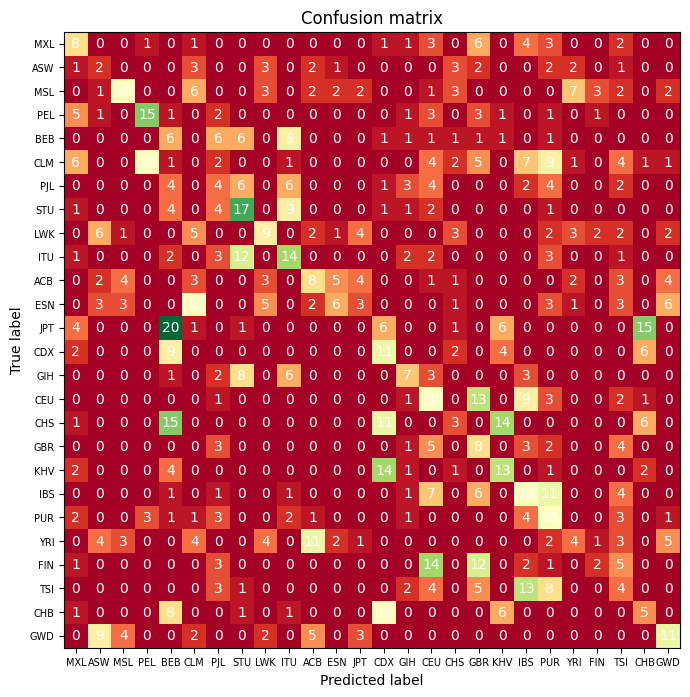

In [400]:
plot_confusion_matrix(discriminator_results["class_real"], discriminator_results["class_pred"])

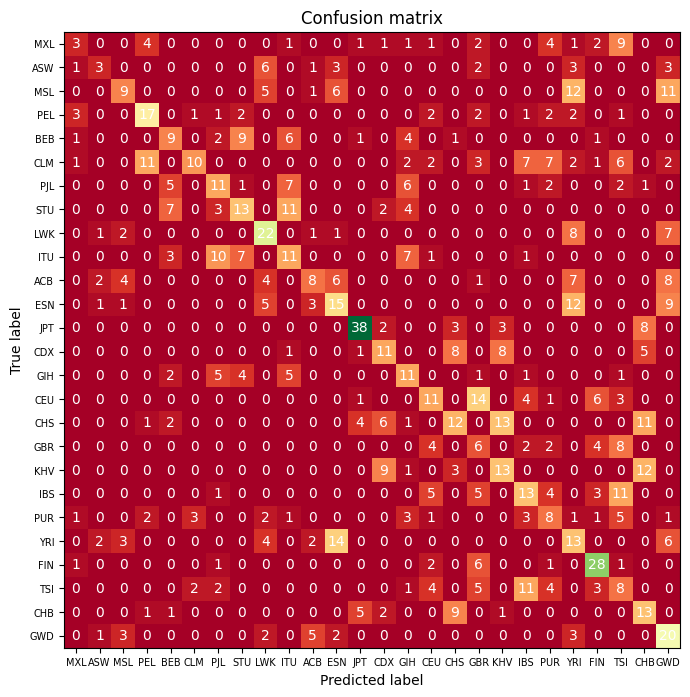

In [401]:
plot_confusion_matrix(catboost_results["class_real"], catboost_results["class_pred"])


In [402]:
def plot_bar_comparison(y_real, y_pred):
    # plot a bar chart of the number of true and predicted labels side by side
    fig, ax = plt.subplots(figsize=(12, 6))
    counts_real = np.zeros(len(labels))
    counts_pred = np.zeros(len(labels))
    width = 0.4
    positions = np.arange(len(labels))
    for i in range(len(y_real)):
        counts_real[int(y_real[i])] += 1
        counts_pred[int(y_pred[i])] += 1
    ax.bar(positions - width / 2, counts_real, width=width, color='blue', label='True label')
    ax.bar(positions + width / 2, counts_pred, width=width, color='red', label='Predicted label')
    ax.set_xlabel('Label')
    ax.set_ylabel('Number of samples')
    ax.set_xticklabels(class_names)
    plt.title('True vs. predicted label distribution')
    ax.set_xticks(positions)
    ax.legend()

    # add the numbers on each bar
    for i in range(len(positions)):
        ax.text(positions[i] - width / 2, counts_real[i] + 0.1, str(int(counts_real[i])), ha='center')
        ax.text(positions[i] + width / 2, counts_pred[i] + 0.1, str(int(counts_pred[i])), ha='center')

    plt.savefig(os.path.join(output_dir, "distribution_comparison.jpg"))
    plt.show()

/var/folders/gg/cdx7t5lx167_frdvqm0mxt5c0000gn/T/ipykernel_45212/4203789197.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names)


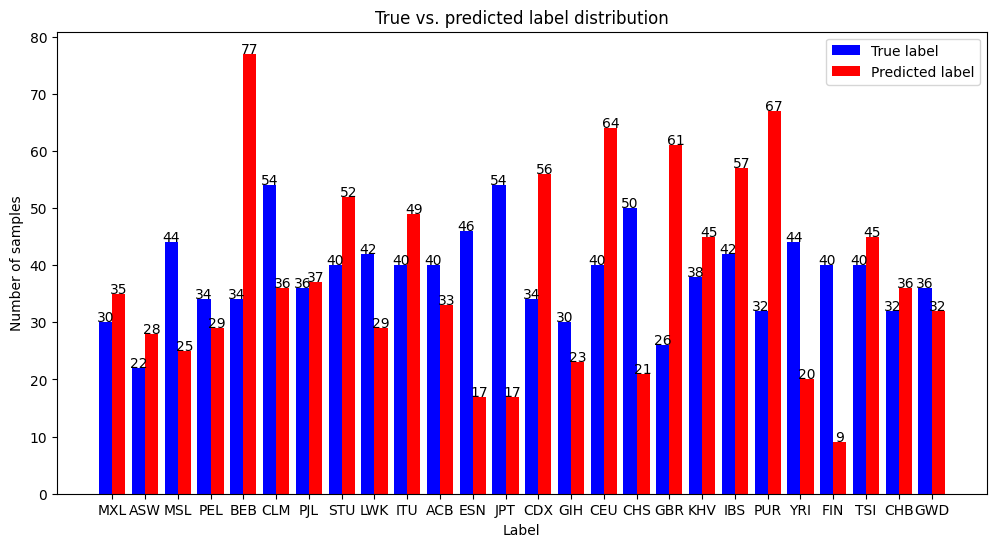

In [403]:
plot_bar_comparison(discriminator_results["class_real"], discriminator_results["class_pred"])

/var/folders/gg/cdx7t5lx167_frdvqm0mxt5c0000gn/T/ipykernel_45212/4203789197.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names)


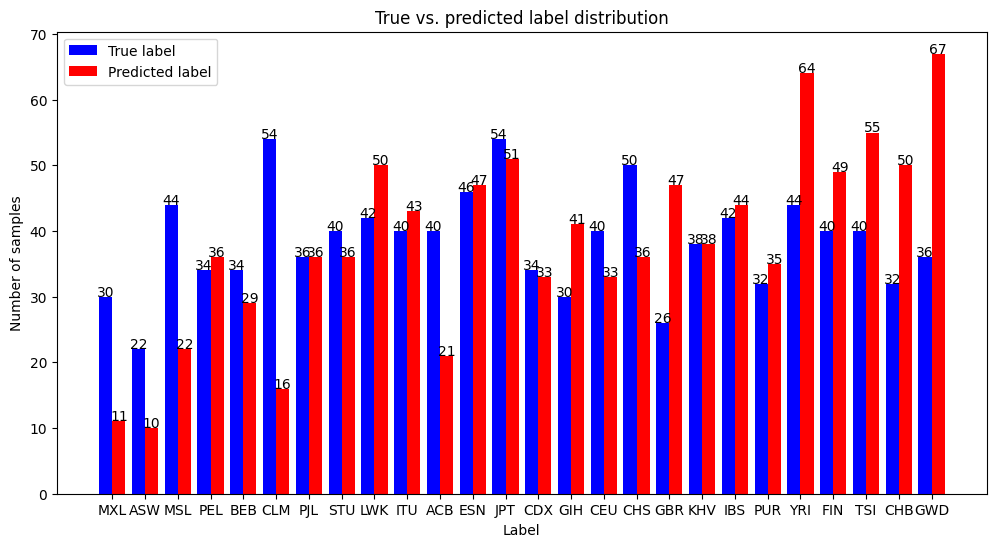

In [404]:
plot_bar_comparison(catboost_results["class_real"], catboost_results["class_pred"])


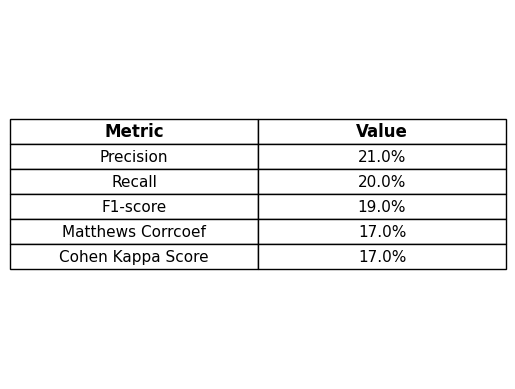

In [405]:
from matplotlib.font_manager import FontProperties
import pandas as pd
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score, cohen_kappa_score


def plot_metrics(y_true, y_pred):
    # Compute evaluation metrics
    cks = f"{round(cohen_kappa_score(y_true, y_pred), 2) * 100}%"
    mc = f"{round(matthews_corrcoef(y_true, y_pred), 2) * 100}%"
    precision = f"{round(precision_score(y_true, y_pred, average='weighted'), 2) * 100}%"
    recall = f"{round(recall_score(y_true, y_pred, average='weighted'), 2) * 100}%"
    f1 = f"{round(f1_score(y_true, y_pred, average='weighted'), 2) * 100}%"

    # Create a table with the metrics
    metrics = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-score', 'Matthews Corrcoef', 'Cohen Kappa Score'],
        'Value': [precision, recall, f1, mc, cks]
    })

    fig, ax = plt.subplots()
    ax.axis('off')
    table = ax.table(cellText=metrics.values, colLabels=metrics.columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 1.5)

    # set font properties for header cells
    font_props = FontProperties(weight='bold', size=12)
    for i, col in enumerate(metrics.columns):
        table[(0, i)].set_text_props(fontproperties=font_props)

    # save the visualization as a JPEG image
    plt.savefig(os.path.join(output_dir, "distribution_metrics.jpg"))


plot_metrics(discriminator_results["class_real"], discriminator_results["class_pred"])

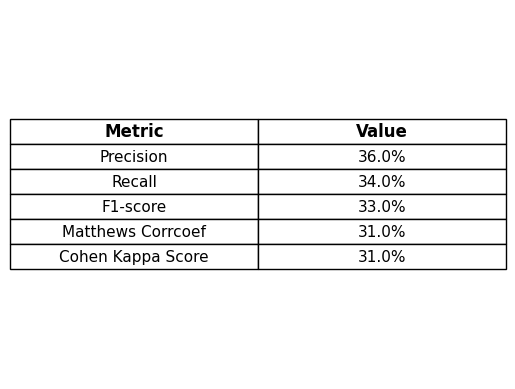

In [406]:
plot_metrics(catboost_results["class_real"], catboost_results["class_pred"])

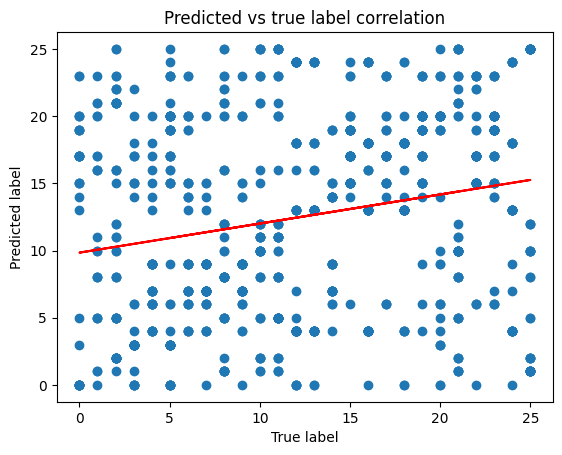

In [407]:
def plot_correlation(y_real, y_pred):
    # plot a scatter plot of predicted vs true labels with a trendline
    fig, ax = plt.subplots()
    ax.scatter(y_real, y_pred)
    m, b = np.polyfit(y_real, y_pred, 1)
    ax.plot(y_real, m * y_real + b, color='red')
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')
    plt.title('Predicted vs true label correlation')
    plt.savefig(os.path.join(output_dir, "correlation_predict_vs_real.jpg"))
    plt.show()


plot_correlation(discriminator_results["class_real"], discriminator_results["class_pred"])

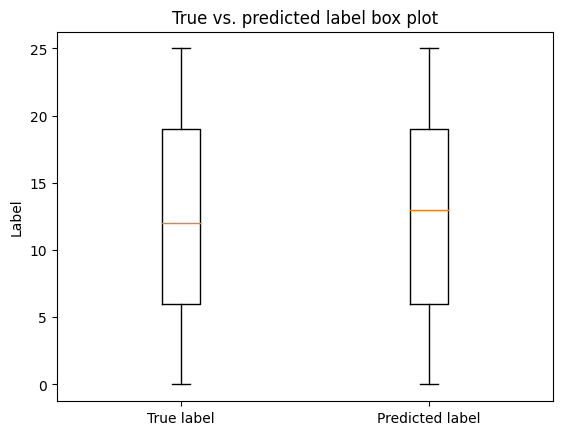

In [408]:
def plot_box(y_real, y_pred):
    # plot a box plot of the true and predicted labels
    fig, ax = plt.subplots()
    data = [y_real, y_pred]
    ax.boxplot(data, labels=['True label', 'Predicted label'])
    ax.set_ylabel('Label')
    ax.set_title('True vs. predicted label box plot')
    plt.show()


plot_box(discriminator_results["class_real"], discriminator_results["class_pred"])